In [1]:
%matplotlib inline
# Import dev version of friedrich:
import sys
sys.path.insert(0, '../')

import numpy as np
import matplotlib.pyplot as plt
from friedrich.analysis import Transit, Spot, Measurement, MCMCResults
from friedrich.lightcurve import hat11_params_morris
from glob import glob

archive_paths = sorted(glob('/local/tmp/friedrich/hat11/chains???.hdf5'))

print('load results')
transits = []
all_times = []
for archive_path in archive_paths:
    m = MCMCResults(archive_path, hat11_params_morris())
    all_times.extend(m.lc.times.jd)

    spots = m.get_spots()
    transits.append(Transit(spots, time=m.lc.times.jd.mean()))

load results


In [2]:
from friedrich.orientation import times_to_occulted_lat_lon
from astroML.plotting import plot_tissot_ellipse

transit_params = hat11_params_morris()

all_lats = []
all_lons = []
all_amps = []
all_spot_times = []
all_BICs = []
for transit in transits:
    for spot in transit.spots: 
        latitude, longitude = times_to_occulted_lat_lon(np.array([spot.t0.value]), 
                                                        transit_params, rotate_star=True)
        all_lats.append(latitude)
        all_lons.append(longitude)
        all_amps.append(spot.amplitude.value)
        all_spot_times.append(spot.t0.value)
        all_BICs.append(spot.delta_BIC)
all_lats = np.array(all_lats)
all_lons = np.array(all_lons)
all_amps = np.array(all_amps)
all_spot_times = np.array(all_spot_times)
all_BICs = np.array(all_BICs)

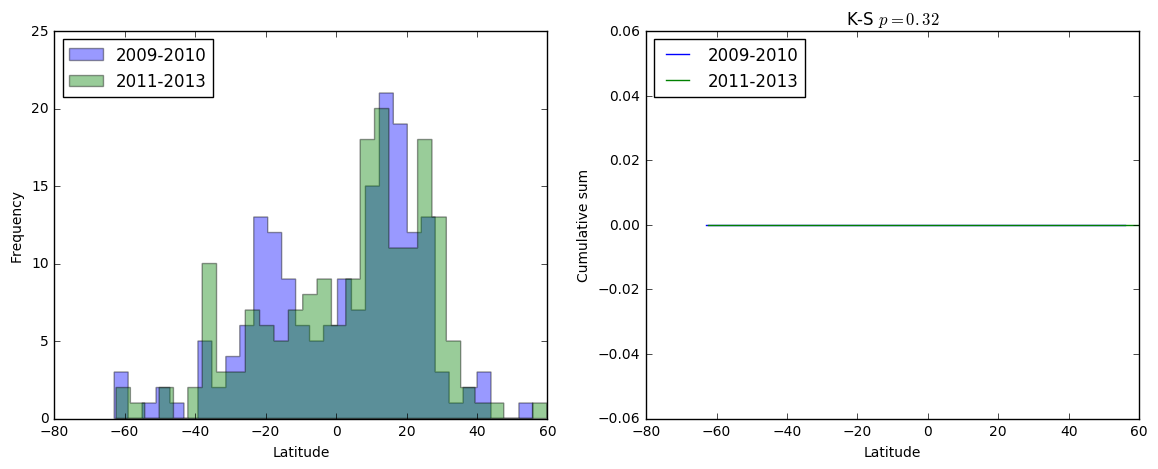

In [3]:
bic_threshold = 20

strong_lats = all_lats[all_BICs > bic_threshold]
strong_lats_times = all_spot_times[all_BICs > bic_threshold]
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
first_half_strong_lats = strong_lats[:int(0.5*len(strong_lats))]
second_half_strong_lats = strong_lats[-len(first_half_strong_lats):]

nbins = 30
ax[0].hist(np.degrees(first_half_strong_lats), nbins, histtype='stepfilled',
           facecolor='b', alpha=0.4, label='2009-2010')
ax[0].hist(np.degrees(second_half_strong_lats), nbins, histtype='stepfilled', 
           facecolor='g', alpha=0.4, label='2011-2013')

def cumdist(Z):
    N = len(Z)
    return np.sort(Z.ravel()), np.arange(N)/N

ax[1].plot(*cumdist(np.degrees(first_half_strong_lats)), label='2009-2010')
ax[1].plot(*cumdist(np.degrees(second_half_strong_lats)), label='2011-2013')

from scipy.stats import ks_2samp
ks = ks_2samp(first_half_strong_lats.ravel(), second_half_strong_lats.ravel())

ax[0].legend(loc='upper left')
ax[0].set(xlabel='Latitude', ylabel='Frequency')
ax[1].legend(loc='upper left')
ax[1].set(xlabel='Latitude', ylabel='Cumulative sum', 
          title="K-S $p={0:.2f}$".format(ks.pvalue))
plt.show()

spots: 362


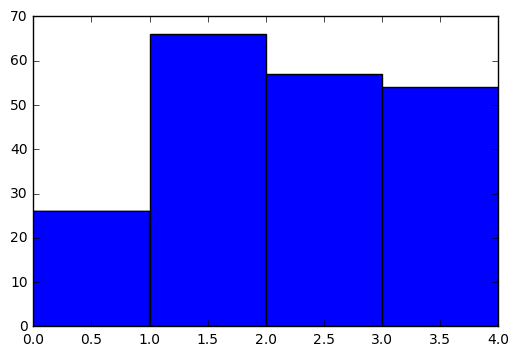

In [6]:
spots_per_transit = np.zeros(len(transits))
times_each_transit = np.zeros(len(transits))
n_spots = 0
for i, transit in enumerate(transits):
    for spot in transit.spots:
        if spot.delta_BIC > bic_threshold:
            spots_per_transit[i] += 1
            n_spots += 1
    if times_each_transit[i] == 0:
        times_each_transit[i] = transit.time

print('spots: {0}'.format(n_spots))
plt.hist(spots_per_transit, 4);

(-0.5, 4.5)

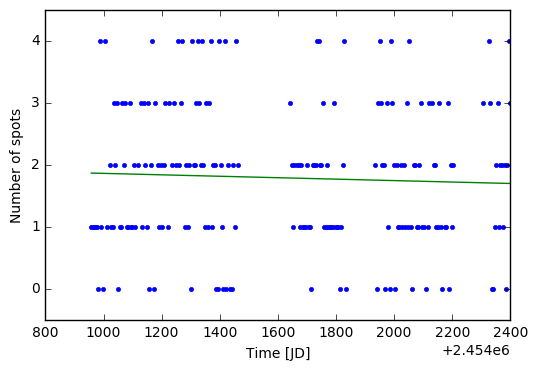

In [25]:
nonzero = times_each_transit != 0
plt.plot(times_each_transit, spots_per_transit, '.')

plt.plot(times_each_transit, 
         np.polyval(np.polyfit(times_each_transit, spots_per_transit, 1), 
                    times_each_transit))
plt.xlabel('Time [JD]')
plt.ylabel('Number of spots')
plt.ylim([-0.5, 4.5])

In [22]:
half_way_point = times_each_transit[0] + times_each_transit.ptp()/2

first_half = times_each_transit < half_way_point
second_half = times_each_transit > half_way_point

N_first_half = np.sum(spots_per_transit[first_half])
N_second_half = np.sum(spots_per_transit[second_half])

print("First half: {} {}".format(N_first_half, np.sqrt(N_first_half)))
print("Second half: {} {}".format(N_second_half, np.sqrt(N_second_half)))

First half: 190.0 13.7840487521
Second half: 172.0 13.1148770486


In [23]:
(N_first_half - N_second_half) / np.sqrt(N_first_half + N_second_half)

0.94605899620974609

In [114]:
import emcee
from scipy.misc import factorial

def lnprior(theta, x):
    m, b = theta
    if (-1 < m < 1) and b > 0 and np.all(m*x + b > 0):
        return 0.0
    return -np.inf

def lnlike(theta, x, y):
    m, b = theta
    lam = m * x + b
    
    # http://mathworld.wolfram.com/MaximumLikelihood.html
    return np.sum(y * np.log(lam) - lam)

def lnprob(theta, x, y):
    lp = lnprior(theta, x)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y)

args = (times_each_transit, spots_per_transit)

from scipy import optimize
chi2 = lambda *args: - lnlike(*args)
result = optimize.minimize(chi2, [0, 2], args=args)

/astro/apps6/opt/anaconda2.0/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in log


In [115]:
(np.exp(-2) + 2**3) / np.math.factorial(3)

1.3558892138727687

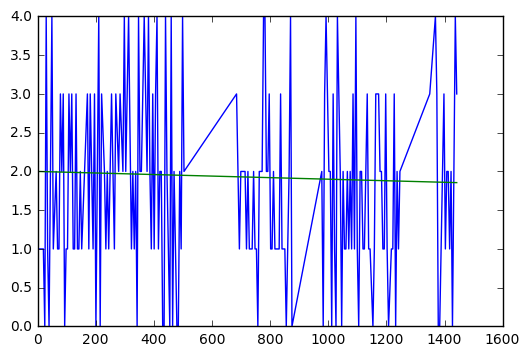

In [136]:
plt.plot(times_each_transit - times_each_transit[0], spots_per_transit)
plt.plot(times_each_transit - times_each_transit[0], 
         np.polyval([-0.0001, 2], times_each_transit - times_each_transit[0]))

In [144]:
ndim, nwalkers = 2, 6
pos = [np.array([-0.0001, 2]) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
                                args=(times_each_transit - times_each_transit[0], spots_per_transit))


In [188]:
N_steps = 15000
N_burnin = 10000
sampler.run_mcmc(pos, N_steps);

In [189]:
samples = sampler.chain[:, N_burnin:, :].reshape((-1, ndim))

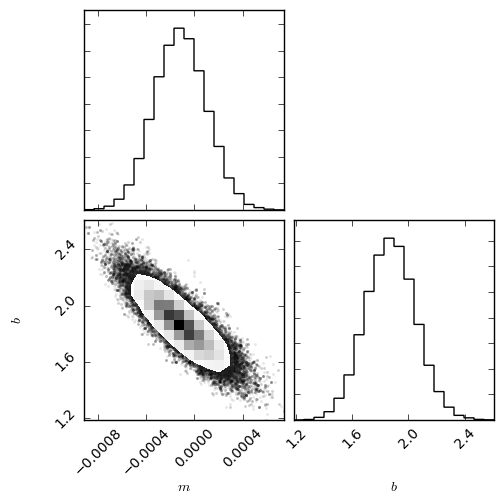

In [190]:
import corner

corner.corner(samples, labels=['$m$', '$b$'])
plt.show()

In [191]:
prob_slope_negative = np.count_nonzero(samples[:, 0] < 0) / float(samples[:,0].size)

print('Probability slope is negative: {}'.format(prob_slope_negative))

Probability slope is negative: 0.705711111111


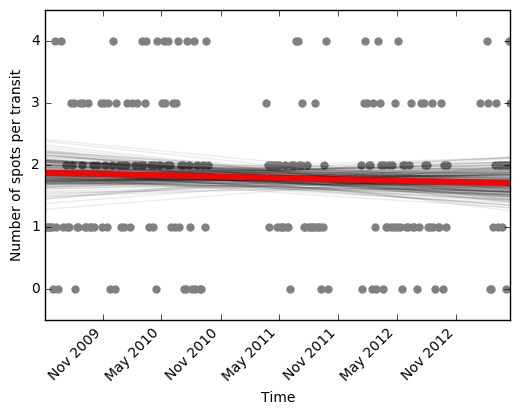

In [200]:
from astropy.time import Time

fig, ax = plt.subplots()
ax.plot_date(Time(times_each_transit, format='jd').plot_date, 
              spots_per_transit, 'o', color='gray', mec='none')

n_random_samples = 200
for i in range(n_random_samples):
    ax.plot_date(Time(times_each_transit, format='jd').plot_date, 
                  np.polyval(samples[np.random.randint(samples.shape[0])], 
                             times_each_transit - times_each_transit[0]), 
                  ls='-', markersize=0, color='k', alpha=0.08)

def best_fit_model(times):
    return np.polyval(np.median(samples, axis=0), times)
    
ax.plot_date(Time(times_each_transit, format='jd').plot_date, 
              best_fit_model(times_each_transit - times_each_transit[0]), 
              ls='-', markersize=0, color='r', lw=4)
    
ax.set_xlabel('Time')
ax.set_ylabel('Number of spots per transit')
ax.set_ylim([-0.5, 4.5])

for l in ax.get_xticklabels():
    l.set_rotation(45)
    l.set_ha('right')


Poisson distribution: 
$$ f(k; \lambda)=\frac{\lambda^k e^{-\lambda}}{k!}$$


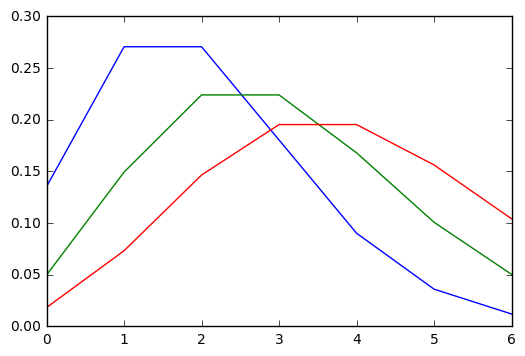

In [199]:
def poisson(k, lam):
    return (lam**k * np.exp(-lam)) / factorial(k)

lam = 2
k = np.array([0, 1, 2, 3, 4, 5, 6])
plt.plot(k, poisson(k, 2))
plt.plot(k, poisson(k, 3))
plt.plot(k, poisson(k, 4))

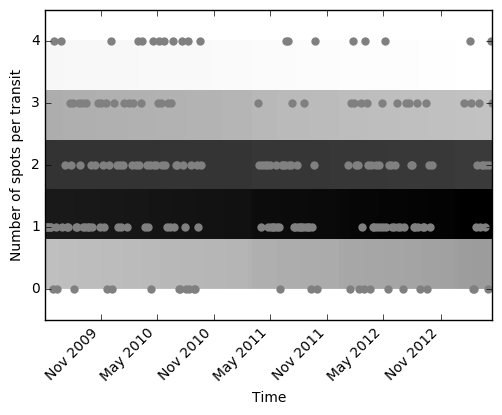

In [225]:
dist = np.zeros((5, len(spots_per_transit)))

k = np.array([0, 1, 2, 3, 4])

for i in range(len(spots_per_transit)):
    dist[:, i] = poisson(k, best_fit_model(times_each_transit[i] - times_each_transit[0]))


fig, ax = plt.subplots()
ax.plot_date(Time(times_each_transit, format='jd').plot_date, 
             spots_per_transit, 'o', color='gray', mec='none')

first_time = Time(times_each_transit, format='jd').plot_date[0]
last_time = Time(times_each_transit, format='jd').plot_date[-1]
ax.imshow(dist, extent=[first_time, last_time, 0, 4], 
          cmap=plt.cm.Greys, origin='lower', interpolation='nearest')

ax.set_xlabel('Time')
ax.set_ylabel('Number of spots per transit')
ax.set_ylim([-0.5, 4.5])

ax.set_aspect(200)

# n_random_samples = 200
# for i in range(n_random_samples):
#     ax.plot_date(Time(times_each_transit, format='jd').plot_date, 
#                   np.polyval(samples[np.random.randint(samples.shape[0])], 
#                              times_each_transit - times_each_transit[0]), 
#                   ls='-', markersize=0, color='w', alpha=0.08)


for l in ax.get_xticklabels():
    l.set_rotation(45)
    l.set_ha('right')
